# CAR BOOST demonstration notebook

#### In the following notebook we will display how the `carboost` protocol is applied to predict a CAR construct with maximal responsiveness.
#### For this demonstration purpose we will be predicting an optimal CAR hinge sequence length (derived from CD8 $\alpha$) targetting **CD22 receptor**.


![alternative text](img/fig3_f_targetsl.png)

#### Following the protocol mentioned above we will be modelling the target recepor first to extract its end-to-end distance distribution a synapse. Generally, target modelling can fall into 2 categories

##### (1) **Category 1**: Target receptor contains a disordered hinge-like region connecting an ordered extracellular domain to the anchoring transmembrane domain
##### (2) **Category 2**: Target receptor does not contain any disordered hinge-like region.

##### Further based on the type of modeling the `carboost` protocol has the two following modes:
##### (a) `target_type` = "dynamic": This mode models the target as an ensemble irrespective of its category
##### (a) `target_type` = "rigid": This mode models the target as a rigid system. In cases of targets like CD20 this mode of `carboost` can be used.

<img src="img/target_classification.png" alt="alternative text" width="500">


***

## 1. Target modelling

Target: **CD22**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md

#@markdown Please provide the seuquence of the extracellular domain of the target receptor

Extra_cellular_region_sequence = 'QYPPKKVTTVIQNPMPIREGDTVTLSCNYNSSNPSVTRYEWKPHGAWEEPSLGVLKIQNVGWDNTTIACAACNSWCSWASPVALNVQYAPRDVRVRKIKPLSEIHSGNSVSLQCDFSSSHPKEVQFFWEKNGRLLGKESQLNFDSISPEDAGSYSCWVNNSIGQTASKAWTLEVLYAPRRLRVSMSPGDQVMEGKSATLTCESDANPPVSHYTWFDWNNQSLPYHSQKLRLEPVKVQHSGAYWCQGTNSVGKGRSPLSTLTVYYSPE' #@param {type:"string"}

#@markdown Please provide the seuquence of the transmembrane domain of the target receptor

TM_region_sequence = 'TIGRR' #@param {type:"string"} 

#@markdown Please provide the epitope region for the target receptor. Discontinous regions are separated with a ','.

epitope_region = '210-216,223-225,232-235' #@param {type:"string"}

zero_based_index = False #@param {type:"boolean"}

target_sequence = Extra_cellular_region_sequence+TM_region_sequence

if zero_based_index:
    epitope_region = [[int(resid) for resid in region.split('-')] for region in epitope_region.split(',')]
else:
    epitope_region = [[int(resid)-1 for resid in region.split('-')] for region in epitope_region.split(',')]

## 1.a Target tertiary and secondary structure analysis

A regular Alphafold2 run with colabfold is performed to assess the structure of the target receptor (CD22). In this demo notebook we will be using previously generated structures. However, the following code block from `carboost` can be used to generate structure. 

```
from carboost.folding import ColabFoldRunConfig, run_colabfold_pipeline

config = ColabFoldRunConfig(
    query_sequence = target_sequence,
    num_seeds = 1,
    max_msa='512:1024'
)

summary = run_colabfold_pipeline(
    config=config,
    output_dir="CD22",
    zip_output=True,
    show_msa_plot=False,
    show_prediction_plot=False,
)
```

In [2]:
#@title Interactive visualization of the target receptor

top_file = 'data/CD22/pred_1.pdb'

from carboost.utils.plot_utils import view_molecule

view_molecule(top_file,color_regions=True,regions=[[len(Extra_cellular_region_sequence),len(target_sequence)],epitope_region],colormap='Set1')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [3]:
#@title Assiging the category for target modelling

ss_info = md.compute_dssp(md.load(top_file))[0]
last_10_indices = np.arange(len(Extra_cellular_region_sequence),len(Extra_cellular_region_sequence)-10,-1)
ss_info_last_10 = ss_info[last_10_indices]

if ss_info_last_10[ss_info_last_10=='C'].shape[0] < 7:
    from IPython.display import Markdown, display
    target_category = 2
    display(Markdown("## Category 2"))
    display(Markdown("### No hinge like region present"))
    display(Markdown("### Modeling the extracellular region **along with the** TM region."))
    
else:
    from carboost.receptor.receptor_utils import find_hinge_like_region 
    hinge_sequence = find_hinge_like_region(Extra_cellular_region_sequence,ss_info[0:len(Extra_cellular_region_sequence)])
    target_category = 1
    from IPython.display import Markdown, display
    display(Markdown("## Category 1"))
    display(Markdown("### A possible hinge like region is present."))
    display(Markdown("### Modeling the hinge like region and the ordered domain **seperately**"))
    display(Markdown(f"### Using rMSA AF2 for TM+hinge: `{hinge_sequence+TM_region_sequence}`"))

## Category 2

### No hinge like region present

### Modeling the extracellular region **along with the** TM region.

## 1.b Target ensemble modeling for the target

Target ensemble modeling is performed in the following to get the end-to-end distance distribution.

Following code block was used in colab notebook to perform reduced MSA AF2 with Colabfold

```
config = ColabFoldRunConfig(
    query_sequence = target_sequence, # since category 2
    num_seeds = 64, # A total 320 structure
    max_msa='8:16' # reducing MSA information
)

summary = run_colabfold_pipeline(
    config=config,
    output_dir="CD22",
    zip_output=True,
    show_msa_plot=False,
    show_prediction_plot=False,
)
```

In [4]:
#@title Filtering the generated structures and calculating the end-to-end distances
#@markdown values for `start`(epitope region),`stop`(beginning of TM region), and `last_res`(last residue used to fix the membrane plane) are calculated automatically from the above analysis. However, `last_res` and `last_residue_offset` are essentially free parameters.
from carboost.receptor import EndToEndCalculatorCOM

e2e_com = EndToEndCalculatorCOM(
    top = top_file,
    tol = 0,
    last_res=len(target_sequence)-1,
    start = epitope_region,
    stop = [[len(target_sequence)-len(TM_region_sequence)-1,len(target_sequence)-len(TM_region_sequence)-1]],
    last_residue_offset=0
)
total_number = 320
samplefiles = [f"data/CD22/pred_{i+1}.pdb" for i in range(total_number)]


kept_files, dist_vals, cos_dist_vals = e2e_com.get_e2e(samplefiles,apply_membrane_filter=True)


Percentage of structure after geometry filter to account for membrane(%): 96.5625


100%|██████████| 309/309 [01:26<00:00,  3.57it/s]


Text(0.5, 0, 'z$_{e2e}$, nm')

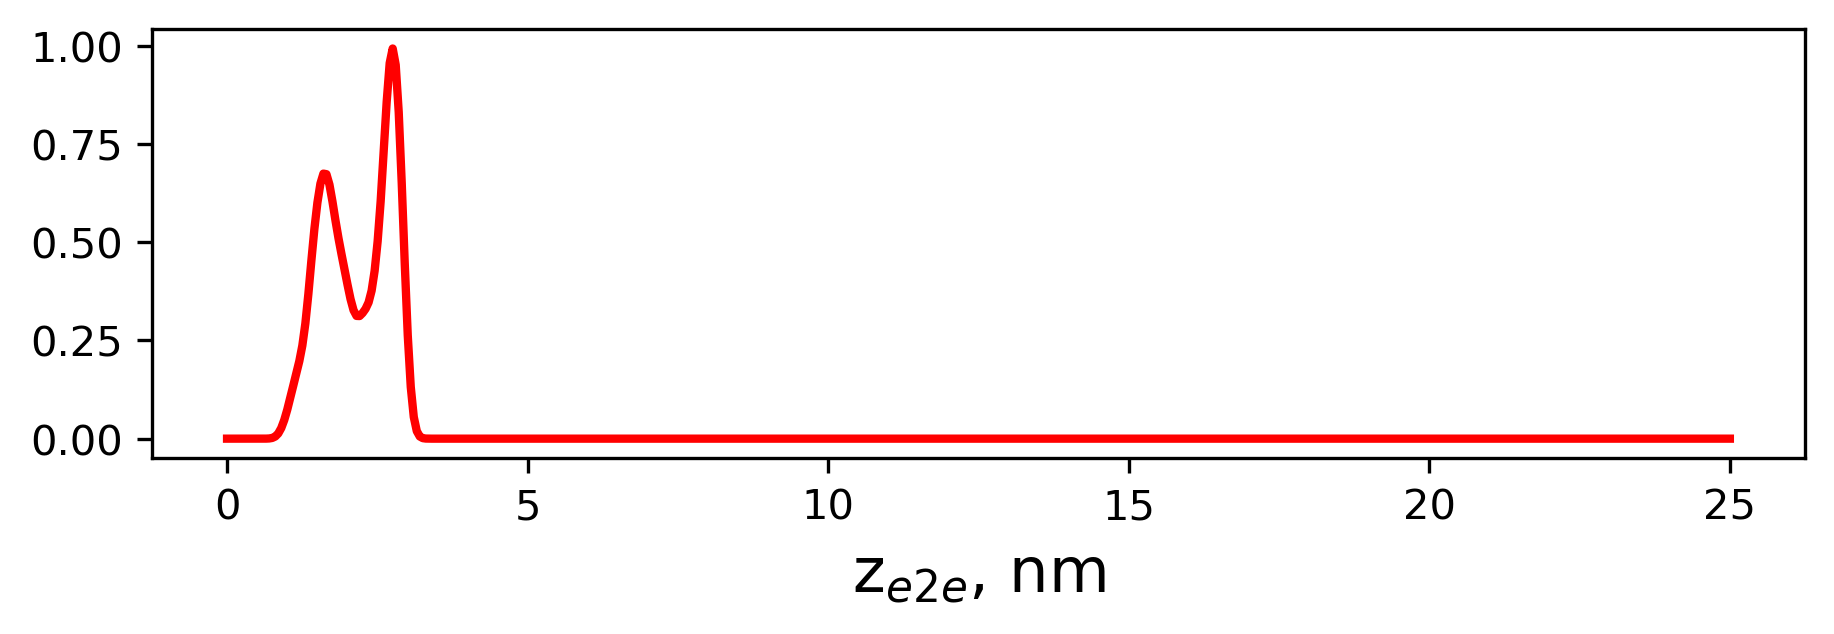

In [5]:
#@title KDE density estimation for the target receptor

#@markdown For category 1 receptor, please provide the offset value due to the end-to-end distance of the ordered domain.

target_offset_value = 0 #@param {type:"number"}
if target_category == 2:
   target_offset_value = 0
 
from carboost.synapse.synapse_utils import get_KDE

xx=np.linspace(0,25,num=500)
x_vals=np.reshape(xx,(xx.shape[0],1))

dist = np.array(cos_dist_vals) + target_offset_value
dist = np.reshape(dist,(dist.shape[0],1))
prb = get_KDE(yval=dist,xval=x_vals,bandwidth=0.1)

probab_target = prb
max_target = max(dist)
xvals_target = x_vals
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(6,2),dpi=300,constrained_layout=True)
ax.plot(xx,prb,linewidth=2,c='r')
ax.set_xlabel("z$_{e2e}$, nm",fontsize=15)

## 2. CAR receptors

We will be loading the pre calculated KDEs from af2rave generated distribution used in the manuscript and $z_{e2e}$ distances from reduced MSA AF2.

In [6]:
hinge_sequence_lengths = [3,8,15,27,33,40,47,51,56,61,76,91]

In [7]:
#@markdown offset values from the scFv domain of the CAR receptor

car_offset_value = 4.0 #nm

xx=np.linspace(0,25,num=500)
x_vals=np.reshape(xx,(xx.shape[0],1))
probab_cars = {}
from importlib import resources as importlib_resources
resource_af2rave = importlib_resources.files("carboost").joinpath("resources", "CD8alpha", "af2rave")
resource_rmsa = importlib_resources.files("carboost").joinpath("resources", "CD8alpha", "rMSA_AF2")

# This section is added to the plot_utils.py for easy loading of KDEs when predicting optimal CAR hinge sequence length for any other target receptor.

for hh_idx, hinge_len in enumerate(hinge_sequence_lengths):
    probab_cars[hinge_len]={}
    if hinge_len > 8:
        prb = np.load(resource_af2rave / f"probab_8H{hinge_len}.npy")
        probab_cars[hinge_len]['kdes']= prb
        probab_cars[hinge_len]['xval']= x_vals
    else:
        dist = np.load(resource_rmsa / f"ze2e_8H{hinge_len}_wt.npy")
        dist = np.reshape(dist,(dist.shape[0],1))
        probab_cars[hinge_len]['kdes']= get_KDE(yval=dist,xval=x_vals,bandwidth=0.8).reshape(1,-1)
        probab_cars[hinge_len]['xval']= x_vals

import pickle
# Pre-existing max hinge values.
with open(resource_af2rave / "max_hinge_values.pkl","rb") as f:
    max_hinge_zvalues = pickle.load(f)

In [8]:
#@title 3. Predicting `Phi` values
from carboost.synapse.synapse import run_carboost_pipeline, SynapseBase

Phi_values = {}
for hh_idx, hinge_len in enumerate(hinge_sequence_lengths):
    syn = SynapseBase(car_name=f"8H{hinge_len}",
                      hinge_length=f"{hinge_len}",
                      target_type="dynamic",
                      target_kde=probab_target,
                      car_kdes=probab_cars[hinge_len]['kdes'],
                      method_name='af2rave',
                      x_car=xx,
                      x_target=xx,
                      max_val_car=max_hinge_zvalues[hinge_len],
                      max_val_target=max(cos_dist_vals),
                      offset_value=4)
    Phi_values[hinge_len]={}
    Phi_values[hinge_len]['phi']=run_carboost_pipeline(syn)['phi']
    Phi_values[hinge_len]['phi_err']=run_carboost_pipeline(syn)['phi_err']

Text(0, 0.5, '$\\phi$ values')

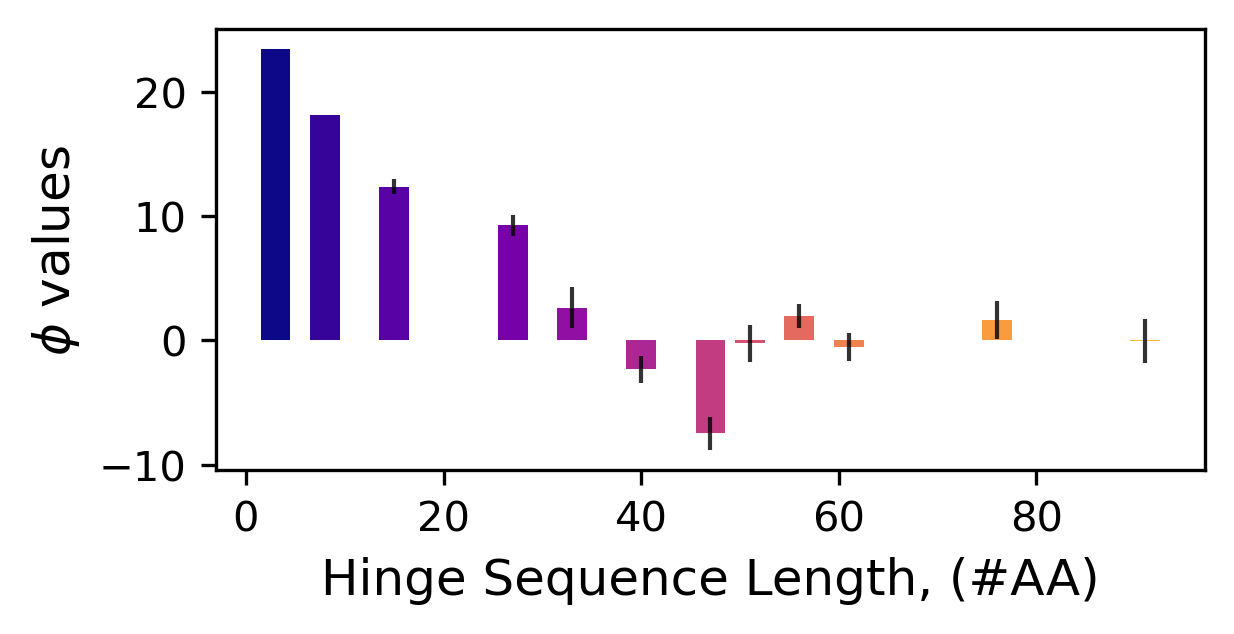

In [9]:
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(4,2),dpi=300,constrained_layout=True)
colors = plt.cm.plasma(np.linspace(0, 1, len(hinge_sequence_lengths)+2))
for hh_idx, hinge_len in enumerate(hinge_sequence_lengths):
    ax.errorbar(hinge_len,Phi_values[hinge_len]['phi'],yerr=Phi_values[hinge_len]['phi_err'],c='k',linewidth=1,alpha=0.8) 
    ax.bar(hinge_len,Phi_values[hinge_len]['phi'],color=colors[hh_idx],width=3)
ax.set_xlabel("Hinge Sequence Length, (#AA)",fontsize=12)
ax.set_ylabel("$\phi$ values",fontsize=12)

### The $\phi$ values are a sum of $\Delta G$s as defined in the manuscript. Thus, more negative the $\phi$ value better the performance from the CAR construct